In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import torch
from tqdm import tqdm


import olga.load_model as load_model
import olga.generation_probability as pgen
import olga.sequence_generation as seq_gen


from sklearn.utils import resample
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

from my_model import CustomModel, PT5_classification_model, train_per_protein, create_dataset

There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB
[2024-05-10 22:31:34,469] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

In [3]:
import os.path
#os.chdir("./")
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [4]:
def process_types(string, typ = 'A'):
    
    pattern = f'[A-Z]+?\d+'
    res = re.search(pattern, string)[0]
    return res#.replace(typ, '', 1)


def add_spaces(seq):
     return ' '.join(list(seq))



def generate_seqs(gene='j', chain='B', counts=1000):
    pref = 'OLGA/olga/'
    if chain == 'B':
        params_file_name = pref + 'default_models/human_T_beta/model_params.txt'
        marginals_file_name = pref + 'default_models/human_T_beta/model_marginals.txt'
        V_anchor_pos_file = pref + 'default_models/human_T_beta/V_gene_CDR3_anchors.csv'
        J_anchor_pos_file = pref + 'default_models/human_T_beta/J_gene_CDR3_anchors.csv'
        
        genomic_data = load_model.GenomicDataVDJ()
        genomic_data.load_igor_genomic_data(params_file_name, V_anchor_pos_file, J_anchor_pos_file)

        generative_model = load_model.GenerativeModelVDJ()
        generative_model.load_and_process_igor_model(marginals_file_name)
        
        seq_gen_model = seq_gen.SequenceGenerationVDJ(generative_model, genomic_data)
        
    elif chain == 'A':
        params_file_name = pref + 'default_models/human_T_alpha/model_params.txt'
        marginals_file_name = pref + 'default_models/human_T_alpha/model_marginals.txt'
        V_anchor_pos_file = pref + 'default_models/human_T_alpha/V_gene_CDR3_anchors.csv'
        J_anchor_pos_file = pref + 'default_models/human_T_alpha/J_gene_CDR3_anchors.csv'
        
        genomic_data = load_model.GenomicDataVJ()
        genomic_data.load_igor_genomic_data(params_file_name, V_anchor_pos_file, J_anchor_pos_file)

        generative_model = load_model.GenerativeModelVJ()
        generative_model.load_and_process_igor_model(marginals_file_name)
        
        seq_gen_model = seq_gen.SequenceGenerationVJ(generative_model, genomic_data)
        
    
    
    generated = {}
    
    if gene=='j':
        for _ in range(counts):
            res = seq_gen_model.gen_rnd_prod_CDR3()#[1::2]

            if f'TR{chain}J{str(res[-1])}' not in generated.keys():
                generated[f'TR{chain}J{str(res[-1])}'] = [res[1]]
            else:
                generated[f'TR{chain}J{str(res[-1])}'].append(res[1])
                
    elif gene == 'v':
        for _ in range(counts):
            res = seq_gen_model.gen_rnd_prod_CDR3()
            
            if f'TR{chain}V{str(res[-1])}' not in generated.keys():
                generated[f'TR{chain}V{str(res[-1])}'] = [res[1]]
            else:
                generated[f'TR{chain}V{str(res[-1])}'].append(res[1])
                
    else:
        raise ValueError('Wrong gene type')
        
    return generated

    
def balance_minority(genes: pd.DataFrame, colu, max_count=1000):
    counts = genes[colu].value_counts()
    counts = counts.drop(counts[counts<10].index)
        
    resampled = pd.DataFrame()

    min_classes = (counts[counts<=max_count])
    i=0
    
    #print(colu)
    left_genes = pd.DataFrame()
    mean_clss = counts[counts>max_count].index#[i for i in genes[colu] if i not in min_classes]
    for cl in mean_clss:
        #print(cl)
        left_genes = pd.concat([left_genes, genes[genes[colu]==cl]])
    #print(mean_clss)
    # print(left_genes)
        
    
    while (i < 30) and (min(min_classes) < max_count/4):
        # print('Iter '+str(i))
        i+=1
        generated_seqs_beta = generate_seqs(gene = colu, counts = max_count*100)
        generated_seqs_alpha = generate_seqs(gene = colu, chain = 'A', counts = max_count*100)
        generated_seqs = {**generated_seqs_beta, **generated_seqs_alpha}
        
        #counts_resampled = resampled[colu].value_counts()
        for min_cl in min_classes.index:
            resampled = pd.concat([resampled, genes[genes[colu] == min_cl]])
            #n = counts[min_cl] if counts[min_cl]>500 else 500
            if min_cl in generated_seqs.keys():
                for seq_tcr in generated_seqs[min_cl]:
                    resampled.loc[len(resampled.index)] = [seq_tcr, min_cl]
    
        counts_resampled = resampled[colu].value_counts()        
        min_classes = (counts_resampled[counts_resampled<=max_count])
        print(min(min_classes))
        
    return pd.concat([left_genes, resampled])#return resampled#.reset_index()
    
    
def balance_majority(genes: pd.DataFrame, colu, min_count=30, max_count=1500):
    counts = genes[colu].value_counts()
    counts = counts.drop(counts[min_count>counts].index)
    resampled = pd.DataFrame()
    #print(resampled)
    maj_clss = (counts[counts>max_count]).index
    left_genes = pd.DataFrame()
    mean_clss = counts[(counts<max_count) & (min_count<counts)].index#[i for i in genes[colu] if i not in min_classes]
    #print(mean_clss)
    for cl in mean_clss:
        #print(cl)
        left_genes = pd.concat([left_genes, genes[genes[colu]==cl]])
    # resampl_dict = {i: (max_count if i in maj_clss else counts[i]) for i in genes[colu].unique()}
    # #print(resampl_dict)
    # rus = RandomUnderSampler(sampling_strategy=resampl_dict, random_state=42)
    # resampled_X, resampled_y = rus.fit_resample(genes.drop(columns = colu), genes[colu])
    # return pd.concat([resampled_X, resampled_y], axis=1) 
    for maj_cl in maj_clss:
        #print(maj_cl)
        
        resampled = pd.concat([resampled, resample(genes[genes[colu] == maj_cl], replace=False, n_samples=max_count, random_state=42)])
        #genes = genes.drop(genes[genes[colu]==maj_cl].index)
    return pd.concat([left_genes, resampled])

In [5]:
from my_model import save_model, load_model_

In [6]:
from sklearn.preprocessing import MinMaxScaler

def draw_heatmap(pred_labels, ans, l_e, n_cl = None, show=True):
    pred_genes = l_e.inverse_transform(pred_labels)
    ans_genes = l_e.inverse_transform(list(ans))
    
    if not n_cl:
        classes = l_e.classes_
    else:
        classes = l_e.classes_[:n_cl]
    
    matrix = pd.DataFrame(data = 0, columns= classes, index= classes)
    for i in range(len(ans_genes)):
        # try:
        matrix.loc[ans_genes[i], pred_genes[i]] += 1
    
    matrix_norm = MinMaxScaler().fit_transform(matrix.T)
    matrix_norm = pd.DataFrame(data = matrix_norm.T, columns= classes, index= classes)
    
    if show:
        fig, ax = plt.subplots(figsize=(11,9)) 
        
        sns.heatmap(matrix_norm, cmap="Greens")
    return matrix_norm

def norm(dist_matr):
    
    dfmax, dfmin = np.array(dist_matr).max(), np.array(dist_matr).min()

    dist_matr_norm = (dist_matr - dfmin)/(dfmax - dfmin)

    return dist_matr_norm

## Prepare data

In [19]:
alpha_data = pd.read_csv('data/selected_cdr_alpha_440002200808_S159_L002.csv', index_col=0)
beta_data = pd.read_csv('data/selected_cdr_beta_440001980101_S87_L001.csv', index_col=0)

alpha_data['type'] = 0
alpha_data.head()
print(f'Dataset of alpha chain size {alpha_data.shape}')

beta_data['type'] = 1
beta_data.head()
print(f'Dataset of beta chain size {beta_data.shape}')

Dataset of alpha chain size (23065, 4)
Dataset of beta chain size (34345, 5)


In [20]:
alpha_data['v'] = alpha_data['v'].apply(process_types, 'A')
beta_data['v'] = beta_data['v'].apply(process_types, 'B')

alpha_resampl = balance_majority(alpha_data, 'v', min_count=100, max_count=1000)
beta_resampl = balance_majority(beta_data, 'v', min_count=100, max_count=1000)

v_genes = pd.concat([alpha_resampl[['cdr3aa', 'v']], beta_resampl[['cdr3aa', 'v']]], ignore_index=True)

v_test_dataset = v_genes.sample(frac=0.15, random_state=42)
v_genes = v_genes.drop(v_test_dataset.index)
v_genes = v_genes.reset_index(drop=True)

v_genes.head()

,cdr3aa,v
0,CATDPNTGNQFYF,TRAV17
1,CATVPRMDSSYKLIF,TRAV17
2,CATDGAGGFKTIF,TRAV17
3,CATTIGNQFYF,TRAV17
4,CATGPTGANNLFF,TRAV17


In [18]:
#alpha_resampl = balance_majority(alpha_data, 'v', min_count=100, max_count=1000)

<BarContainer object of 29 artists>

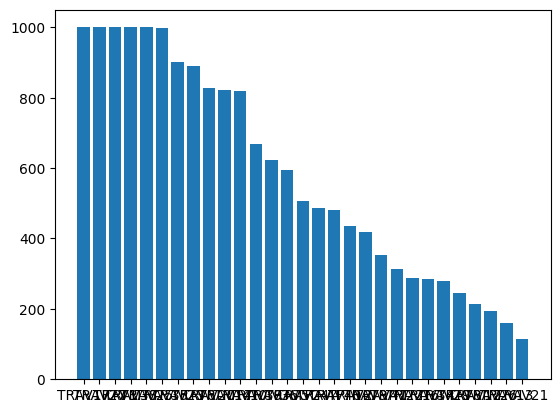

In [10]:
plt.bar(alpha_resampl.v.unique(), alpha_resampl.v.value_counts())

<BarContainer object of 19 artists>

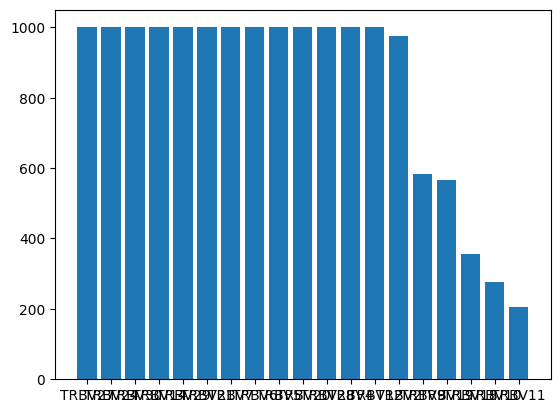

In [11]:
#beta_resampl = balance_majority(beta_data, 'v', min_count=100, max_count=1000)
plt.bar(beta_resampl.v.unique(), beta_resampl.v.value_counts())

In [12]:
v_genes = pd.concat([alpha_resampl[['cdr3aa', 'v']], beta_resampl[['cdr3aa', 'v']]], ignore_index=True)
# v_genes['cdr3aa'] = v_genes['cdr3aa'].map(add_spaces)

In [13]:
v_genes['v'] = v_genes['v'].apply(process_types)


v_test_dataset = v_genes.sample(frac=0.15, random_state=42)
v_genes = v_genes.drop(v_test_dataset.index)
v_genes = v_genes.reset_index(drop=True)

# v_genes.head()

In [14]:
v_uniq = set(v_genes.v.unique())
v_test_uniq = set(v_test_dataset.v.unique())

if not v_test_uniq.issubset(v_uniq):
    print('ADD to train df')
    diff = v_test_uniq.difference(v_uniq)
    for i in diff:
        v_genes.loc[len(v_genes.index)] = [v_test_dataset[v_test_dataset['v'] == i].iloc[0][0], i]
        print(v_test_dataset[v_test_dataset['v'] == i].iloc[0][0], i)
        

<BarContainer object of 48 artists>

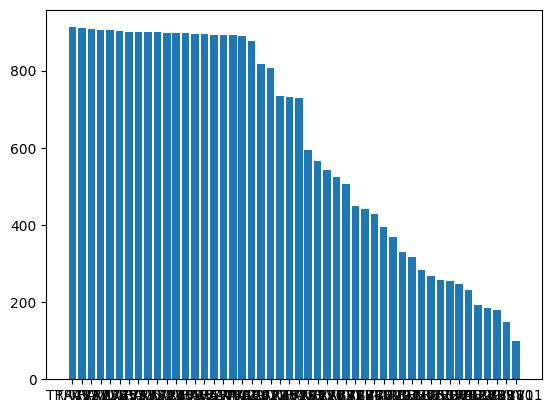

In [15]:
plt.bar(v_genes.v.unique(), v_genes.v.value_counts())
#v_test_dataset.v.value_counts()

In [16]:
v_genes.v.nunique()

48

In [21]:
# v_resampled = balance_minority(v_genes, 'v', max_count=600)
# v_resampled_ = balance_majority(v_resampled, 'v', max_count=600)#.shape
#v_resampled_.to_csv('v_genes_resampled.csv', index=False)


v_resampled = pd.read_csv('v_genes_resampled.csv')
v_resampled

,cdr3aa,v
0,CALGWGYQKVTF,TRAV4
1,CLVGSLYGGATNKLIF,TRAV4
2,CLVGDDTGGFKTIF,TRAV4
3,CLVAWGANNARLMF,TRAV4
4,CLLAPGGFKTIF,TRAV4
...,...,...
28144,CAFQTGANNLFF,TRAV24
28145,CARPSNTGKLIF,TRAV24
28146,CAFQTGANNLFF,TRAV24
28147,CAFKNQGGKLIF,TRAV24


In [22]:
v_resampled.v.nunique()

48

<BarContainer object of 48 artists>

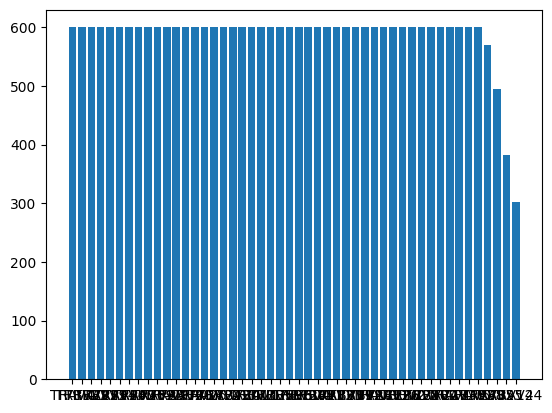

In [23]:
plt.bar(v_resampled.v.unique(), v_resampled.v.value_counts())

In [24]:
# v_resampl = v_resampled.copy()
v_uniq = set(v_resampled.v.unique())
v_test_uniq = set(v_test_dataset.v.unique())

if not v_test_uniq.issubset(v_uniq):
    print('ADD to train df')
    diff = v_test_uniq.difference(v_uniq)
    for i in diff:
        v_resampled.loc[len(v_resampled.index)] = [v_test_dataset[v_test_dataset['v'] == i].iloc[0][0], i]
        print(v_test_dataset[v_test_dataset['v'] == i].iloc[0][0], i)
        

In [25]:
#from sklearn.preprocessing import LabelEncoder
v_resampled['cdr3aa'] = v_resampled['cdr3aa'].apply(add_spaces)
v_test_dataset['cdr3aa'] = v_test_dataset['cdr3aa'].apply(add_spaces)

l_enc = LabelEncoder()
l_enc.fit(v_resampled['v'])#np.append(v_resampl['v'], v_test_dataset['v']))
v_resampled['v'] = l_enc.transform(v_resampled['v'])
v_test_dataset['v'] = l_enc.transform(v_test_dataset['v'])


In [26]:
mapping = dict(zip(l_enc.classes_, range(len(l_enc.classes_))))
mapping

{'TRAV1': 0,
 'TRAV10': 1,
 'TRAV12': 2,
 'TRAV13': 3,
 'TRAV14': 4,
 'TRAV16': 5,
 'TRAV17': 6,
 'TRAV2': 7,
 'TRAV20': 8,
 'TRAV21': 9,
 'TRAV22': 10,
 'TRAV23': 11,
 'TRAV24': 12,
 'TRAV25': 13,
 'TRAV26': 14,
 'TRAV27': 15,
 'TRAV29': 16,
 'TRAV34': 17,
 'TRAV35': 18,
 'TRAV36': 19,
 'TRAV38': 20,
 'TRAV39': 21,
 'TRAV4': 22,
 'TRAV40': 23,
 'TRAV41': 24,
 'TRAV5': 25,
 'TRAV6': 26,
 'TRAV8': 27,
 'TRAV9': 28,
 'TRBV10': 29,
 'TRBV11': 30,
 'TRBV12': 31,
 'TRBV14': 32,
 'TRBV18': 33,
 'TRBV19': 34,
 'TRBV2': 35,
 'TRBV20': 36,
 'TRBV21': 37,
 'TRBV24': 38,
 'TRBV27': 39,
 'TRBV28': 40,
 'TRBV29': 41,
 'TRBV30': 42,
 'TRBV4': 43,
 'TRBV5': 44,
 'TRBV6': 45,
 'TRBV7': 46,
 'TRBV9': 47}

In [27]:
v_resampled.head()

,cdr3aa,v
0,C A L G W G Y Q K V T F,22
1,C L V G S L Y G G A T N K L I F,22
2,C L V G D D T G G F K T I F,22
3,C L V A W G A N N A R L M F,22
4,C L L A P G G F K T I F,22


In [28]:
v_test_dataset = v_test_dataset.reset_index(drop=True)
v_ans = v_test_dataset['v']

v_test_dataset = v_test_dataset.drop(columns=['v'])

In [29]:
v_test_dataset.head()

,cdr3aa
0,C A E S M R T G G S Y I P T F
1,C A S Y Q G G S N Y G Y T F
2,C A G D G G A Q K L V F
3,C A M G W G G Y N K L I F
4,C I L S Y T G N Q F Y F


In [26]:
v_resampled

,cdr3aa,v
0,C A L G W G Y Q K V T F,22
1,C L V G S L Y G G A T N K L I F,22
2,C L V G D D T G G F K T I F,22
3,C L V A W G A N N A R L M F,22
4,C L L A P G G F K T I F,22
...,...,...
28144,C A F Q T G A N N L F F,12
28145,C A R P S N T G K L I F,12
28146,C A F Q T G A N N L F F,12
28147,C A F K N Q G G K L I F,12


## Train the model

### Prottrans

In [27]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(v_resampled, test_size=0.2, random_state=42)

In [28]:
train_df = train_df.rename({'cdr3aa': 'sequence', 'v': 'label'}, axis=1)
val_df = val_df.rename({'cdr3aa': 'sequence', 'v': 'label'}, axis=1)
train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
val_df["sequence"]=val_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    
val_df

,sequence,label
9325,C A L S E L Q F R D N Y G Q N F V F,10
1569,C A A S L D G G S Q G N L I F,16
18806,C A V S G T G Y S T L T F,27
6478,C G A D M S G G A T N K L I F,17
13586,C A S R T S G G G Y N E Q F F,45
...,...,...
20631,C A S R K G T G G A G K N I Q Y F,35
14293,C S A R D V R G V G Y G Y T F,36
9440,C A V G I S N T G K L I F,10
26635,C A D V T F N N A G N M L T F,13


In [29]:
N_LABELS = len(v_resampled.v.value_counts())

tokenizer, model, history = train_per_protein(train_df, val_df, num_labels=N_LABELS, batch=8, accum=8, epochs=10, seed=42)

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.7.layer.2.DenseReluDense.wi.weight', 'decoder.block.23.layer.1.EncDecAttention.k.weight', 'decoder.block.13.layer.0.SelfAttention.o.weight', 'decoder.block.23.layer.0.layer_norm.weight', 'decoder.block.2.layer.2.layer_norm.weight', 'decoder.block.14.layer.1.EncDecAttention.v.weight', 'decoder.block.5.layer.1.EncDecAttention.o.weight', 'decoder.block.5.layer.2.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.6.layer.0.SelfAttention.q.weight', 'decoder.block.20.layer.0.SelfAttention.k.weight', 'decoder.block.13.layer.0.SelfAttention.v.weight', 'decoder.block.0.layer.1.EncDecAttention.o.weight', 'decoder.block.8.layer.0.SelfAttention.q.weight', 'decoder.block.11.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.0.SelfAttention.v.weight', 'decoder.block.6.layer.2.layer_norm.weight', 'decoder.block.20.layer.1.EncDecAt

ProtT5_Classfier
Trainable Parameter: 1209240624
ProtT5_LoRA_Classfier
Trainable Parameter: 3606576

[2024-03-20 14:34:03,130] [INFO] [comm.py:637:init_distributed] cdb=None
[2024-03-20 14:34:03,131] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
[2024-03-20 14:34:03,157] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.14.0, git-hash=unknown, git-branch=unknown
[2024-03-20 14:34:16,605] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False


Using /home/akabalina/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/akabalina/.cache/torch_extensions/py39_cu117/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module cpu_adam...


ninja: no work to do.
Time to load cpu_adam op: 3.36329984664917 seconds
[2024-03-20 14:34:29,271] [INFO] [logging.py:96:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adamw as basic optimizer
[2024-03-20 14:34:29,272] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2024-03-20 14:34:29,325] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = DeepSpeedCPUAdam
[2024-03-20 14:34:29,326] [INFO] [utils.py:56:is_zero_supported_optimizer] Checking ZeRO support for optimizer=DeepSpeedCPUAdam type=<class 'deepspeed.ops.adam.cpu_adam.DeepSpeedCPUAdam'>
[2024-03-20 14:34:29,326] [INFO] [logging.py:96:log_dist] [Rank 0] Creating torch.float32 ZeRO stage 2 optimizer
[2024-03-20 14:34:29,327] [INFO] [stage_1_and_2.py:149:__init__] Reduce bucket size 200000000
[2024-03-20 14:34:29,328] [INFO] [stage_1_and_2.py:150:__init__] Allgather bucket size 200000000
[2024-03-20 14:34:29,329] [INFO] [stage_1_and_2.py:151:__init_

***** Running training *****
  Num examples = 22519
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 8
  Total optimization steps = 3510
  Number of trainable parameters = 3606576


Adam Optimizer #0 is created with AVX512 arithmetic capability.
Config: alpha=0.000300, betas=(0.900000, 0.999000), weight_decay=0.000000, adam_w=1


Epoch,Training Loss,Validation Loss,Accuracy
0,2.503800,1.682116,0.490053
1,1.629700,1.525825,0.521670
2,1.506000,1.492846,0.543872
3,1.444500,1.473256,0.544938
4,1.403200,1.419973,0.561456
5,1.367700,1.410535,0.562522
6,1.338600,1.429758,0.564654
7,1.320000,1.411070,0.565542
8,1.295400,1.399225,0.575488
9,1.277900,1.400493,0.569982


***** Running Evaluation *****
  Num examples = 5630
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5630
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5630
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5630
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5630
  Batch size = 16


[2024-03-20 15:27:25,459] [INFO] [logging.py:96:log_dist] [Rank 0] step=2000, skipped=0, lr=[0.0003], mom=[[0.9, 0.999]]
[2024-03-20 15:27:25,461] [INFO] [timer.py:260:stop] epoch=0/micro_step=16000/global_step=2000, RunningAvgSamplesPerSec=43.79355073339056, CurrSamplesPerSec=43.87363056025633, MemAllocated=4.53GB, MaxMemAllocated=8.31GB


***** Running Evaluation *****
  Num examples = 5630
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5630
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5630
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5630
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5630
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




In [30]:
my_test=v_test_dataset.rename({'cdr3aa': 'sequence'}, axis=1)
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)

my_test.head(5)

,sequence
0,C A E S M R T G G S Y I P T F
1,C A S Y Q G G S N Y G Y T F
2,C A G D G G A Q K L V F
3,C A M G W G G Y N K L I F
4,C I L S Y T G N Q F Y F


In [33]:
# #save_model(model,"./models_ft/Prottrans_v_genes_finetuned.pth")
N_LABELS = len(v_resampled.v.value_counts())
tokenizer_, model_reload = load_model_("./models_ft/Prottrans_v_genes_finetuned.pth", num_labels=N_LABELS, mixed=False)

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.20.layer.0.SelfAttention.k.weight', 'decoder.block.13.layer.0.SelfAttention.q.weight', 'decoder.block.15.layer.2.DenseReluDense.wi.weight', 'decoder.block.18.layer.2.DenseReluDense.wo.weight', 'decoder.block.22.layer.0.layer_norm.weight', 'decoder.block.22.layer.2.layer_norm.weight', 'decoder.block.4.layer.1.EncDecAttention.v.weight', 'decoder.block.1.layer.1.EncDecAttention.q.weight', 'decoder.block.7.layer.1.EncDecAttention.o.weight', 'decoder.block.20.layer.1.EncDecAttention.q.weight', 'decoder.block.2.layer.2.DenseReluDense.wi.weight', 'decoder.block.5.layer.1.EncDecAttention.k.weight', 'decoder.block.14.layer.2.DenseReluDense.wo.weight', 'decoder.block.17.layer.0.SelfAttention.q.weight', 'decoder.block.4.layer.1.EncDecAttention.o.weight', 'decoder.block.6.layer.0.SelfAttention.k.weight', 'decoder.block.15.layer.1.EncDecAttention.q.weight', 'decoder.bl

ProtT5_Classfier
Trainable Parameter: 1209240624
ProtT5_LoRA_Classfier
Trainable Parameter: 3606576



In [34]:
# create Dataset
test_set=create_dataset(tokenizer_, list(my_test['sequence']),list(v_ans))
# test_set=create_dataset(tokenizer, list(my_test['sequence']),list(v_ans))

test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=8, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()
# model.eval()

# Make predictions on the test dataset
predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #add batch results(logits) to predictions
        predictions += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
        # predictions += model(input_ids, attention_mask=attention_mask).logits.tolist()

100%|██████████| 617/617 [00:43<00:00, 14.20it/s]


In [35]:
predictions= [item.argmax() for item in np.array(predictions)]
print("F1 score: ", f1_score(list(v_ans), predictions, average='macro'))

F1 score:  0.48953115192835445


In [29]:
wrond_ans = v_ans[v_ans != predictions].index

In [81]:
# for ind in wrond_ans[0::1000]:
#     print(v_test_dataset.loc[ind].cdr3aa.replace(' ', ''))
#     print(f'Predicted label: {predictions[ind]}. Correct label: {v_ans.loc[ind]}')

### TCR-bert

In [42]:
N_LABELS = v_resampled['v'].nunique()

In [43]:
N_LABELS


48

In [38]:
my_model_ = CustomModel(n_labels=N_LABELS)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([48, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([48]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
input_ids, attention_masks, labels = my_model_.tokenize(v_resampled['cdr3aa'], v_resampled['v'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [140]:
v_resampled['v'].unique()

array([22, 41, 37, 16,  4,  1, 23,  5, 21, 11, 28, 17,  8,  7, 26, 38, 10,
       42, 24, 46,  6, 44, 47, 45, 36, 43, 30,  3,  9, 34, 31, 33, 27,  2,
       14, 35, 40, 29, 39, 15,  0, 19, 25, 20, 18, 13, 32, 12])

In [48]:
train_dataset, val_dataset = my_model_.split_data(input_ids, attention_masks, labels)

22,519 training samples
5,630 validation samples


In [50]:
my_model_.fit(train_dataset, val_dataset, epochs=8)


======== Epoch 1 / 8 ========
Training...

  Average training loss: 1.80
  Training epcoh took: 0:01:10

Running Validation...
  Accuracy: 0.56
  Validation Loss: 1.42
  Validation took: 0:00:04

======== Epoch 2 / 8 ========
Training...

  Average training loss: 1.38
  Training epcoh took: 0:01:04

Running Validation...
  Accuracy: 0.58
  Validation Loss: 1.37
  Validation took: 0:00:04

======== Epoch 3 / 8 ========
Training...

  Average training loss: 1.27
  Training epcoh took: 0:01:04

Running Validation...
  Accuracy: 0.59
  Validation Loss: 1.34
  Validation took: 0:00:04

======== Epoch 4 / 8 ========
Training...

  Average training loss: 1.16
  Training epcoh took: 0:01:04

Running Validation...
  Accuracy: 0.59
  Validation Loss: 1.32
  Validation took: 0:00:04

======== Epoch 5 / 8 ========
Training...

  Average training loss: 1.04
  Training epcoh took: 0:01:04

Running Validation...
  Accuracy: 0.59
  Validation Loss: 1.31
  Validation took: 0:00:04

======== Epoch 6 / 

In [51]:
my_model_.get_stats()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.795281,1.422085,0.561841,0:01:10,0:00:04
2,1.384276,1.372336,0.577085,0:01:04,0:00:04
3,1.266410,1.335006,0.585456,0:01:04,0:00:04
4,1.155551,1.317765,0.588829,0:01:04,0:00:04
5,1.038753,1.305994,0.592025,0:01:04,0:00:04
6,0.923784,1.317500,0.604657,0:01:04,0:00:04
7,0.825155,1.330643,0.607117,0:01:04,0:00:04
8,0.744183,1.336148,0.607650,0:01:04,0:00:04


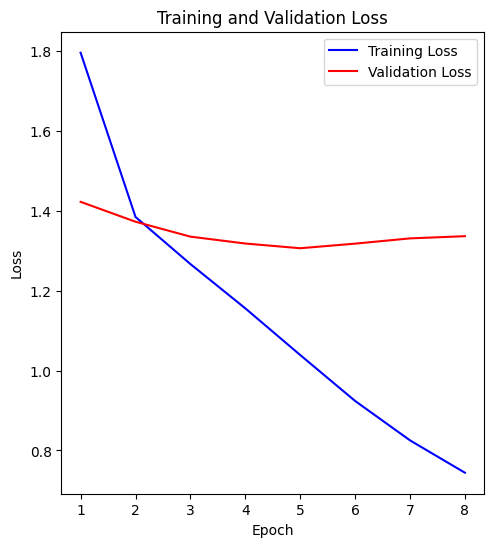

In [52]:
my_model_.draw_stats_plot()

In [39]:
#save_model(my_model_,"./TCR_bert_v_genes_finetuned.pth")

N_LABELS = v_resampled['v'].nunique()
my_model_reload = load_model_("./models_ft/TCR_bert_v_genes_finetuned.pth", mod_type='TCR-bert', num_labels=N_LABELS)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([48, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([48]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
model=my_model_.to("cpu")
model_reload=my_model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


In [40]:
my_model_reload.maximun_len = 25

In [44]:
hid_sts = []
hid_sts_med = []
lbls = []
hid_sts_long = []
# model_tcr.to(device)

for seq in tqdm(v_resampled.index):
    seq, lab = v_resampled.loc[seq]#, v_ans.loc[seq]
    en_dict = my_model_reload.tokenizer.encode_plus(seq, add_special_tokens = True, 
                                      max_length = 25, pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
    input_ids_test, att_mask_test = en_dict['input_ids'], en_dict['attention_mask']
    #my_model.model.eval()

    input_ids_test = input_ids_test.to(device)
    att_mask_test= att_mask_test.to(device)
    #lab = torch.tensor(lab).to(device)

    with torch.no_grad():
        outputs = my_model_reload.model(input_ids_test, att_mask_test, output_hidden_states=True)
        
    hid_sts.append([torch.mean(tensor).item() for tensor in outputs.hidden_states])
    #hid_sts_med.append([torch.median(tensor).item() for tensor in outputs.hidden_states])
    lbls.append(lab)
    emb = torch.mean(torch.mean(torch.mean(torch.stack(list(outputs.hidden_states)), dim=2), dim=1), dim =0)
    hid_sts_long.append(emb.tolist())

  0%|          | 0/28149 [00:00<?, ?it/s]/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 28149/28149 [05:12<00:00, 90.22it/s]


In [45]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

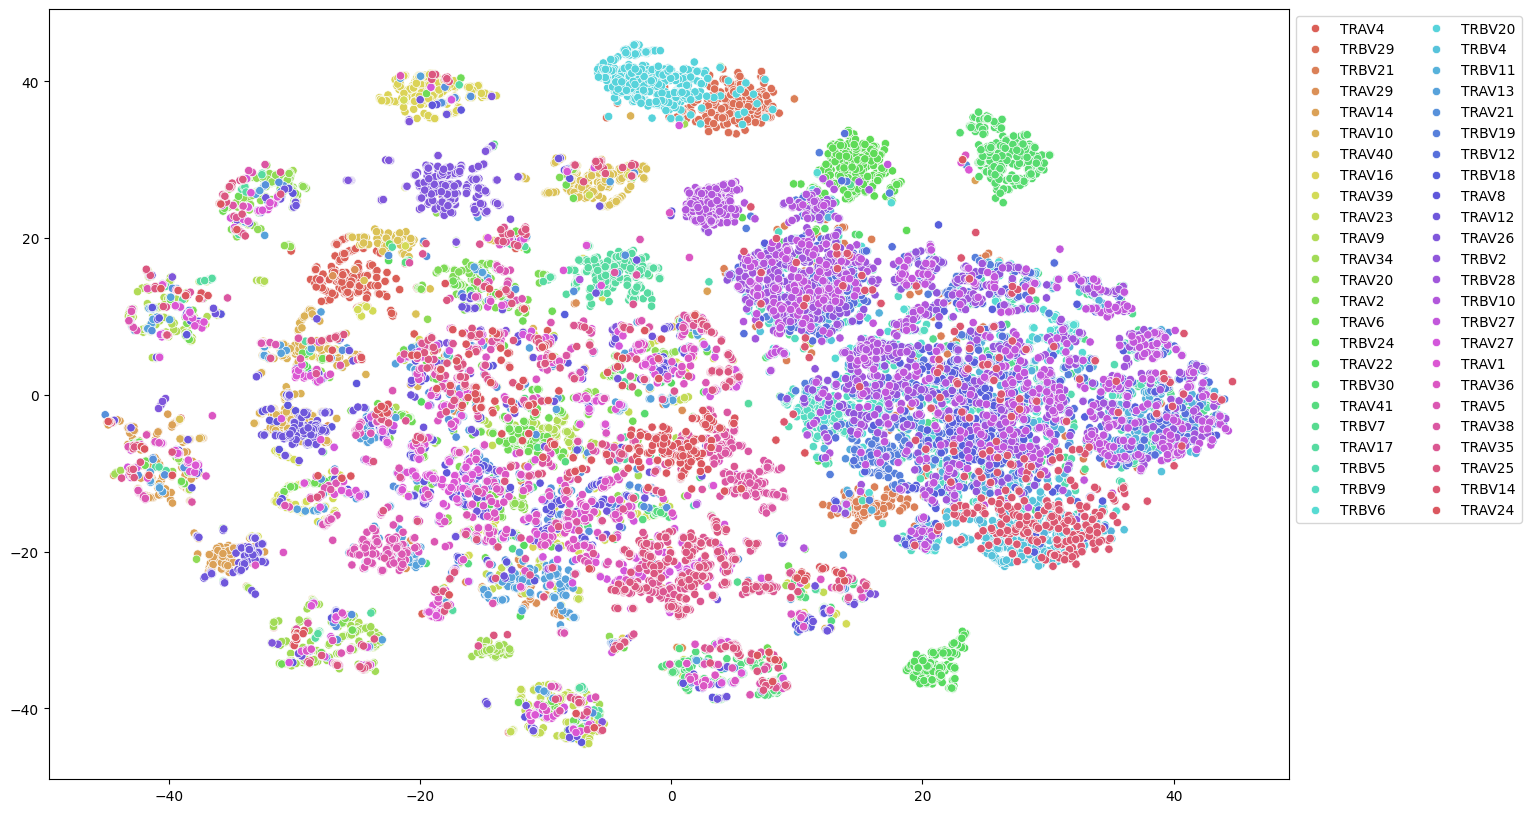

In [47]:
# pca = PCA(n_components=80)#(hid_sts)
# pca_embedding = pca.fit_transform(hid_sts_long)

# tsne = TSNE(n_components=2, n_iter=500, perplexity=80, verbose=1, init=pca_embedding[:, :2], n_jobs=-1)
# tsne_results = tsne.fit_transform(pca_embedding)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=l_enc.inverse_transform(lbls),
    palette=sns.color_palette("hls", 48),
    legend="full",
    alpha=1
)
# plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 2)

In [41]:
my_model_reload.to(device)
v_pred_labels = my_model_reload.predict(v_test_dataset['cdr3aa'])
f1_sc_v = f1_score(v_ans, v_pred_labels, average='macro')
print('Total f1_score: %.5f' % f1_sc_v)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Total f1_score: 0.54011


In [30]:
v_pred_genes = l_enc.inverse_transform(v_pred_labels)
v_ans_genes = l_enc.inverse_transform(list(v_ans))

In [31]:
V = mapping.keys()

In [32]:
matrix_v = pd.DataFrame(data = 0, columns= V, index= V)
for i in range(len(v_ans_genes)):
    matrix_v.loc[v_ans_genes[i], v_pred_genes[i]] += 1

<AxesSubplot: >

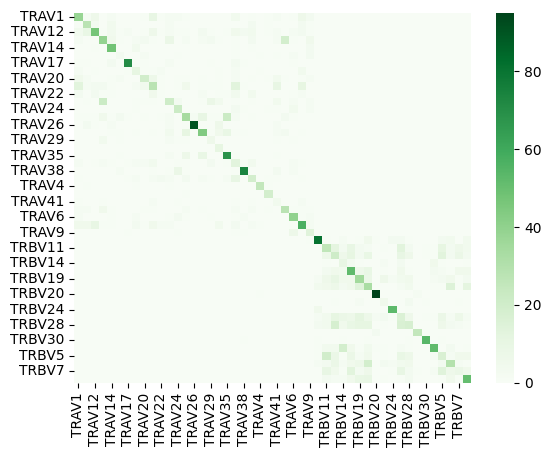

In [33]:
sns.heatmap(matrix_v, cmap="Greens")

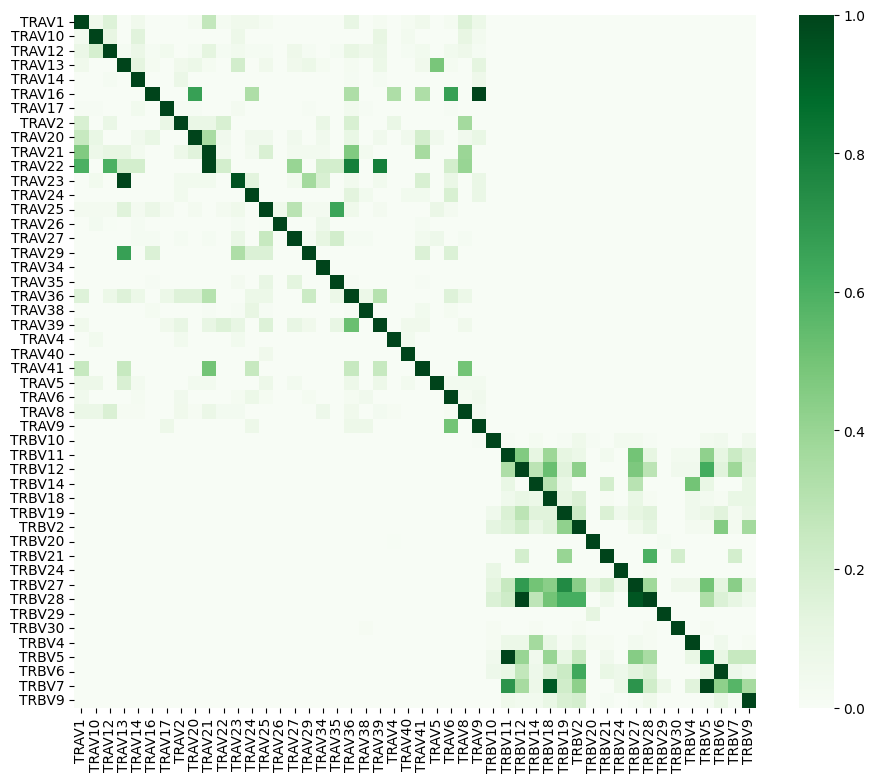

In [51]:
notm_matrix_v = draw_heatmap(v_pred_labels, v_ans, l_enc)

In [29]:
v_test_dataset

,cdr3aa
0,C A E S M R T G G S Y I P T F
1,C A S Y Q G G S N Y G Y T F
2,C A G D G G A Q K L V F
3,C A M G W G G Y N K L I F
4,C I L S Y T G N Q F Y F
...,...
3283,C A S S Q E P N Y G Y T F
3284,C A S S Q D Q G T G K D N E K L F F
3285,C A S S S L L A R G E T Q Y F
3286,C A E N E I T G G G N K L T F


In [30]:
from mir.common.segments import SegmentLibrary
from mir.distances import GermlineAligner

In [36]:
lib = SegmentLibrary.load_default(genes = ['TRA', 'TRB'])
print(lib.get_summary())
print(lib.get_genes())

Counter({('HomoSapiens', 'TRA', 'J'): 49, ('HomoSapiens', 'TRB', 'V'): 48, ('HomoSapiens', 'TRA', 'V'): 45, ('HomoSapiens', 'TRB', 'J'): 13, ('HomoSapiens', 'TRB', 'D'): 2})
{'TRA', 'TRB'}


In [37]:
seqs = lib.get_seqaas('TRA', 'V')
seqs.extend(lib.get_seqaas('TRB', 'V'))
print(seqs[0:3])

[('TRAV1-1*01', 'GQSLEQPSEVTAVEGAIVQINCTYQTSGFYGLSWYQQHDGGAPTFLSYNALDGLEETGRFSSFLSRSDSYGYLLLQELQMKDSASYFCAVR'), ('TRAV1-2*01', 'GQNIDQPTEMTATEGAIVQINCTYQTSGFNGLFWYQQHAGEAPTFLSYNVLDGLEEKGRFSSFLSRSKGYSYLLLKELQMKDSASYLCAVR'), ('TRAV10*01', 'KNQVEQSPQSLIILEGKNCTLQCNYTVSPFSNLRWYKQDTGRGPVSLTIMTFSENTKSNGRYTATLDADTKQSSLHITASQLSDSASYICVVS')]


In [38]:
v_seqs_0 = {process_types(i[0]):i[1] for i in seqs}
v_seqs = {i[0]:i[1] for i in seqs}

In [39]:
v_seqs = list(v_seqs.keys())

In [63]:
pred_labels = v_pred_labels
ans = v_ans

# from Bio import pairwise2
# from Bio.Seq import Seq

pred_genes = l_enc.inverse_transform(pred_labels)
ans_genes = l_enc.inverse_transform(list(ans))
classes0 = v_seqs_0
classes = v_seqs#l_enc.classes_
galn = GermlineAligner.from_seqs(seqs)

# if not n_cl:
#     classes = l_enc.classes_
# else:
#     classes = l_enc.classes_[:n_cl]

dist_matr = pd.DataFrame(data = 0, columns=classes0, index= classes0)
for i in range(len(classes)):
    for j in range(len(classes)):
        try:
            # alignments = pairwise2.align.globalxx(v_seqs[i], v_seqs[j])
            # score = alignments[0].score
            score_norm = galn.score_norm(v_seqs[i], v_seqs[j])
            #print(classes[i])
            dist_matr.loc[process_types(classes[i]), process_types(classes[j])] = -score_norm
        except KeyError:
            pass
            #print(classes[i])
        
dist_matr

,TRAV1,TRAV10,TRAV12,TRAV13,TRAV14,TRAV16,TRAV17,TRAV18,TRAV19,TRAV2,...,TRBV27,TRBV28,TRBV29,TRBV3,TRBV30,TRBV4,TRBV5,TRBV6,TRBV7,TRBV9
TRAV1,0,361,302,395,404,378,377,364,422,367,...,484,455,437,462,406,460,433,475,424,440
TRAV10,361,0,299,360,391,399,266,391,399,394,...,449,440,428,432,408,447,424,456,411,416
TRAV12,302,299,0,308,388,364,340,330,411,388,...,440,434,429,444,391,432,457,456,422,430
TRAV13,395,360,308,0,401,405,328,387,417,422,...,447,458,449,428,444,476,461,468,448,432
TRAV14,404,391,388,401,0,420,381,387,194,437,...,460,422,451,432,448,457,433,461,441,408
TRAV16,378,399,364,405,420,0,400,305,401,377,...,484,458,455,444,410,452,458,477,469,426
TRAV17,377,266,340,328,381,400,0,416,389,399,...,434,428,423,452,417,470,438,452,424,421
TRAV18,364,391,330,387,387,305,416,0,385,399,...,480,476,438,445,414,449,452,475,466,432
TRAV19,422,399,411,417,194,401,389,385,0,439,...,453,430,431,443,470,444,427,450,467,422
TRAV2,367,394,388,422,437,377,399,399,439,0,...,476,461,439,494,447,514,472,496,463,465


<AxesSubplot: >

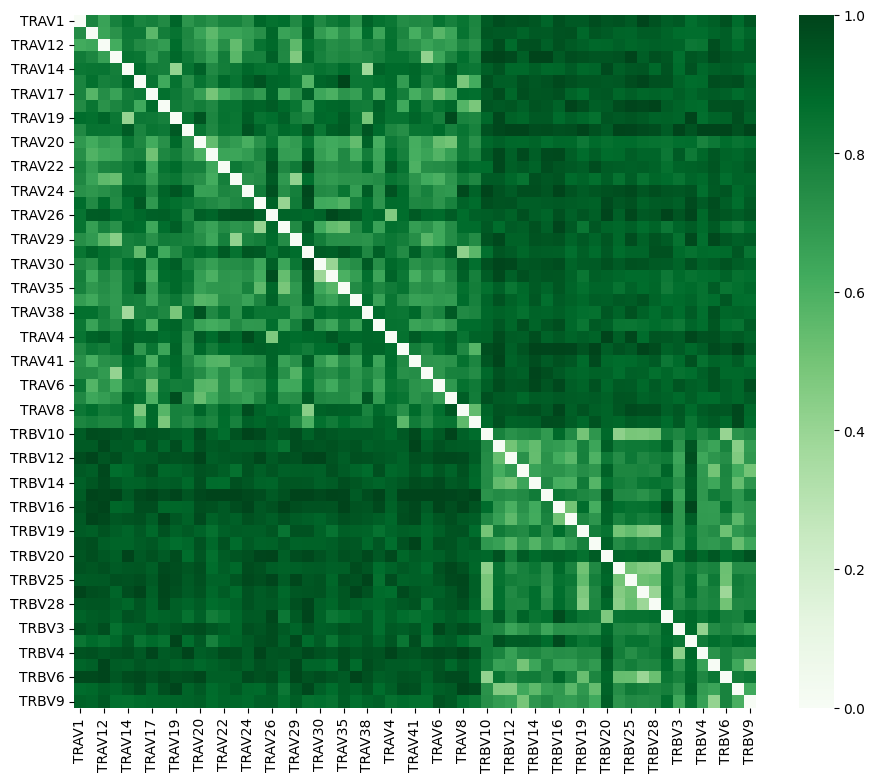

In [64]:
dist_matr_norm = MinMaxScaler().fit_transform(dist_matr)
fig, ax = plt.subplots(figsize=(11,9)) 
dist_matr_norm = pd.DataFrame(data = dist_matr_norm, columns= classes0, index= classes0)
sns.heatmap(dist_matr_norm, cmap="Greens")


In [65]:
dist_matr_norm

,TRAV1,TRAV10,TRAV12,TRAV13,TRAV14,TRAV16,TRAV17,TRAV18,TRAV19,TRAV2,...,TRBV27,TRBV28,TRBV29,TRBV3,TRBV30,TRBV4,TRBV5,TRBV6,TRBV7,TRBV9
TRAV1,0.000000,0.778017,0.657952,0.791583,0.854123,0.780992,0.797040,0.752066,0.897872,0.714008,...,0.995885,0.955882,0.920000,0.935223,0.863830,0.894942,0.917373,0.957661,0.877847,0.946237
TRAV10,0.745868,0.000000,0.651416,0.721443,0.826638,0.824380,0.562368,0.807851,0.848936,0.766537,...,0.923868,0.924370,0.901053,0.874494,0.868085,0.869650,0.898305,0.919355,0.850932,0.894624
TRAV12,0.623967,0.644397,0.000000,0.617234,0.820296,0.752066,0.718816,0.681818,0.874468,0.754864,...,0.905350,0.911765,0.903158,0.898785,0.831915,0.840467,0.968220,0.919355,0.873706,0.924731
TRAV13,0.816116,0.775862,0.671024,0.000000,0.847780,0.836777,0.693446,0.799587,0.887234,0.821012,...,0.919753,0.962185,0.945263,0.866397,0.944681,0.926070,0.976695,0.943548,0.927536,0.929032
TRAV14,0.834711,0.842672,0.845316,0.803607,0.000000,0.867769,0.805497,0.799587,0.412766,0.850195,...,0.946502,0.886555,0.949474,0.874494,0.953191,0.889105,0.917373,0.929435,0.913043,0.877419
TRAV16,0.780992,0.859914,0.793028,0.811623,0.887949,0.000000,0.845666,0.630165,0.853191,0.733463,...,0.995885,0.962185,0.957895,0.898785,0.872340,0.879377,0.970339,0.961694,0.971014,0.916129
TRAV17,0.778926,0.573276,0.740741,0.657315,0.805497,0.826446,0.000000,0.859504,0.827660,0.776265,...,0.893004,0.899160,0.890526,0.914980,0.887234,0.914397,0.927966,0.911290,0.877847,0.905376
TRAV18,0.752066,0.842672,0.718954,0.775551,0.818182,0.630165,0.879493,0.000000,0.819149,0.776265,...,0.987654,1.000000,0.922105,0.900810,0.880851,0.873541,0.957627,0.957661,0.964803,0.929032
TRAV19,0.871901,0.859914,0.895425,0.835671,0.410148,0.828512,0.822410,0.795455,0.000000,0.854086,...,0.932099,0.903361,0.907368,0.896761,1.000000,0.863813,0.904661,0.907258,0.966874,0.907527
TRAV2,0.758264,0.849138,0.845316,0.845691,0.923890,0.778926,0.843552,0.824380,0.934043,0.000000,...,0.979424,0.968487,0.924211,1.000000,0.951064,1.000000,1.000000,1.000000,0.958592,1.000000


In [66]:
inters = notm_matrix_v.index.intersection(dist_matr_norm.index)

In [67]:
m1 = notm_matrix_v.loc[inters, inters]/dist_matr_norm.loc[inters, inters]

m1 = m1.fillna(0)

In [71]:
np.fill_diagonal(m1.values, 0)

<AxesSubplot: >

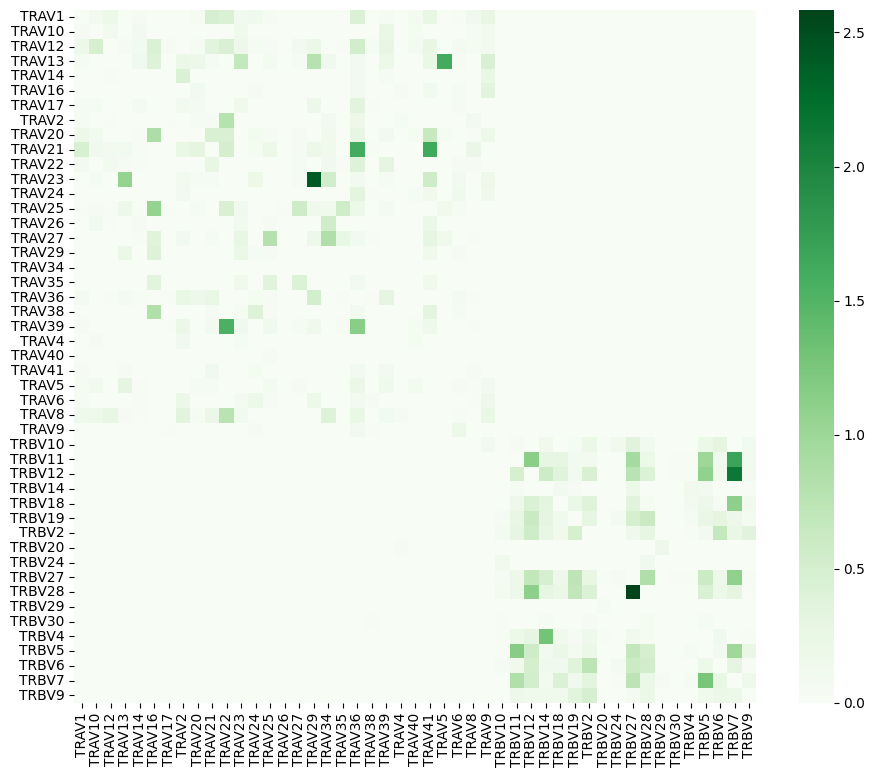

In [72]:
fig, ax = plt.subplots(figsize=(11,9)) 
sns.heatmap(m1, cmap="Greens")

<AxesSubplot: >

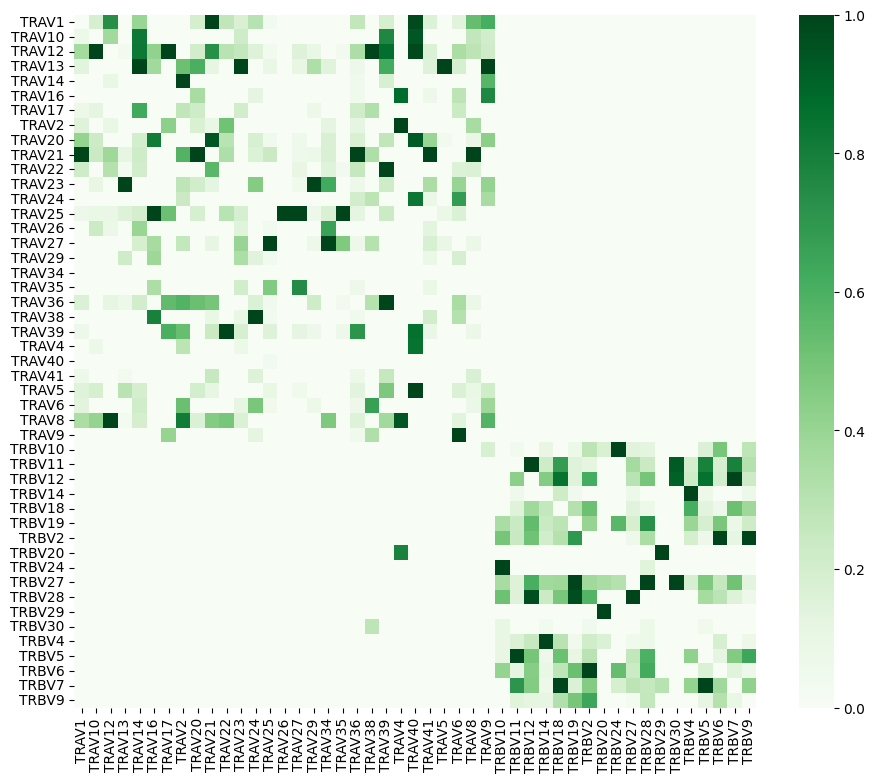

In [73]:

m1_norm = MinMaxScaler().fit_transform(m1)
fig, ax = plt.subplots(figsize=(11,9)) 
m1_norm = pd.DataFrame(data = m1_norm, columns= inters, index= inters)
sns.heatmap(m1_norm, cmap="Greens")

In [70]:
m1#_norm

,TRAV1,TRAV10,TRAV12,TRAV13,TRAV14,TRAV16,TRAV17,TRAV2,TRAV20,TRAV21,...,TRBV24,TRBV27,TRBV28,TRBV29,TRBV30,TRBV4,TRBV5,TRBV6,TRBV7,TRBV9
TRAV1,inf,0.091808,0.194026,0.000000,0.048783,0.000000,0.000000,0.000000,0.064985,0.490570,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TRAV10,0.035282,inf,0.097986,0.000000,0.100810,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TRAV12,0.168700,0.498806,inf,0.041542,0.101589,0.443223,0.039188,0.000000,0.069745,0.360088,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TRAV13,0.064490,0.000000,0.000000,inf,0.122870,0.398354,0.000000,0.221456,0.199696,0.054069,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TRAV14,0.000000,0.000000,0.025170,0.000000,inf,0.000000,0.000000,0.427710,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TRAV16,0.000000,0.000000,0.000000,0.000000,0.000000,inf,0.000000,0.000000,0.117742,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TRAV17,0.033785,0.062299,0.000000,0.000000,0.077592,0.000000,inf,0.117111,0.074237,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TRAV2,0.069411,0.000000,0.025170,0.000000,0.000000,0.000000,0.016697,inf,0.059350,0.046821,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TRAV20,0.188974,0.114681,0.000000,0.000000,0.024697,0.867384,0.000000,0.000000,inf,0.463068,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TRAV21,0.465109,0.121402,0.100680,0.118838,0.026705,0.000000,0.000000,0.250548,0.331818,inf,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [61]:
notm_matrix_v.head()
# dist_matr_norm.head()

,TRAV1,TRAV10,TRAV12,TRAV13,TRAV14,TRAV16,TRAV17,TRAV2,TRAV20,TRAV21,...,TRBV24,TRBV27,TRBV28,TRBV29,TRBV30,TRBV4,TRBV5,TRBV6,TRBV7,TRBV9
TRAV1,1.000000,0.071429,0.127660,0.000000,0.041667,0.000000,0.000000,0.000000,0.05,0.357143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAV10,0.026316,1.000000,0.063830,0.000000,0.083333,0.000000,0.000000,0.000000,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAV12,0.105263,0.321429,1.000000,0.025641,0.083333,0.333333,0.028169,0.000000,0.05,0.214286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAV13,0.052632,0.000000,0.000000,1.000000,0.104167,0.333333,0.000000,0.181818,0.15,0.035714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAV14,0.000000,0.000000,0.021277,0.000000,1.000000,0.000000,0.000000,0.363636,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# galn = GermlineAligner.from_seqs(seqs)
# # print(galn.dist)
# print(galn.score_norm(v_seqs[0], v_seqs[1]))
# print(galn.score_norm('TRBV10-1*01', 'TRBV10-2*01'))

-87.0
-115.0


In [93]:
from mir.common.segments import SegmentLibrary
from mir.distances import GermlineAligner

def mist_dist_heatmap(notm_matrix, gene='V'):
    lib = SegmentLibrary.load_default(genes = ['TRA', 'TRB'])
    seqs = lib.get_seqaas('TRA', gene)
    seqs.extend(lib.get_seqaas('TRB', gene))
    v_seqs_0 = {process_types(i[0]):i[1] for i in seqs}
    v_seqs = {i[0]:i[1] for i in seqs}
    
    v_seqs = list(v_seqs.keys())
    
    classes0 = v_seqs_0
    classes = v_seqs
    galn = GermlineAligner.from_seqs(seqs)

    # if not n_cl:
    #     classes = l_enc.classes_
    # else:
    #     classes = l_enc.classes_[:n_cl]

    dist_matr = pd.DataFrame(data = 0, columns=classes0, index= classes0)
    for i in range(len(classes)):
        for j in range(len(classes)):
            try:
                score_norm = galn.score_norm(v_seqs[i], v_seqs[j])
                dist_matr.loc[process_types(classes[i]), process_types(classes[j])] = -score_norm
            except KeyError:
                pass
            
    dist_matr_norm = MinMaxScaler().fit_transform(1-dist_matr) 
    dist_matr_norm = pd.DataFrame(data = dist_matr_norm, columns= classes0, index= classes0)
    # # dist matrix
    # print(dist_matr_norm)
    #     fig, ax = plt.subplots(figsize=(11,9))
    #     sns.heatmap(dist_matr_norm, cmap="Greens")
    # print(dist_matr_norm)
    inters = notm_matrix.index.intersection(dist_matr_norm.index)
    # notm_matrix = notm_matrix+0.00001
    m1 = notm_matrix.loc[inters, inters]/dist_matr_norm.loc[inters, inters]
    m1 = m1.fillna(0)
    # print(m1)
    # np.fill_diagonal(m1.values, 0) # or 1???
    
    m1_norm = norm(m1)#MinMaxScaler().fit_transform(m1)
    fig, ax = plt.subplots(figsize=(11,9)) 
    # m1_norm = pd.DataFrame(data = m1_norm, columns= inters, index= inters)
    sns.heatmap(m1_norm, cmap="Greens")
    

        

    
    
    

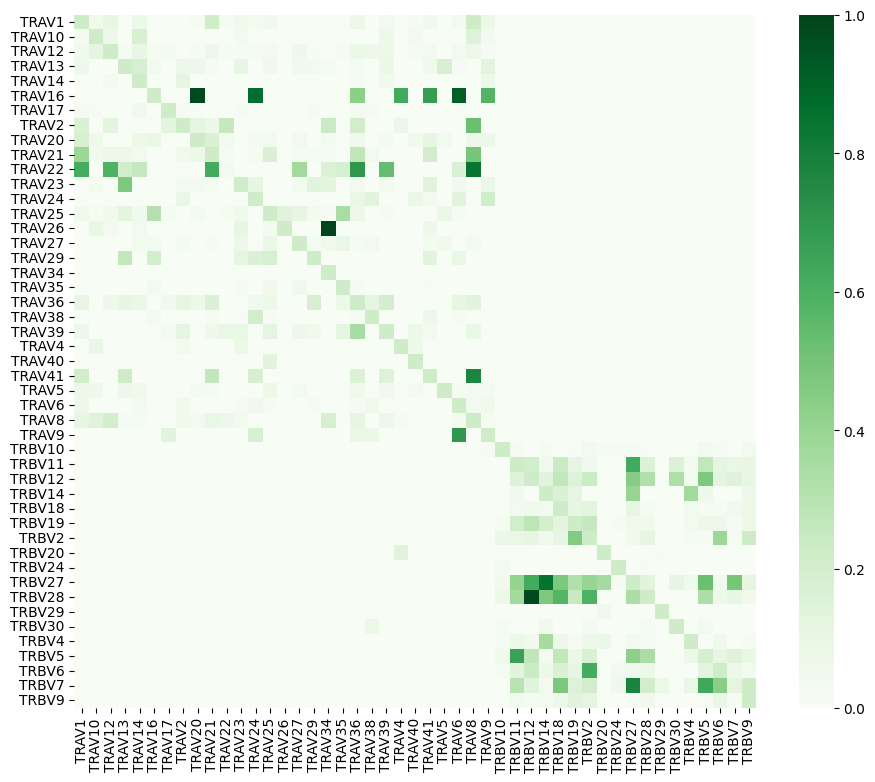

In [94]:
mist_dist_heatmap(notm_matrix_v) 

# J гены

## Prepare data

In [72]:
alpha_data = pd.read_csv('data/selected_cdr_alpha_440002200808_S159_L002.csv', index_col=0)
beta_data = pd.read_csv('data/selected_cdr_beta_440001980101_S87_L001.csv', index_col=0)

alpha_data['type'] = 0
alpha_data.head()
print(f'Dataset of alpha chain size {alpha_data.shape}')

beta_data['type'] = 1
beta_data.head()
print(f'Dataset of beta chain size {beta_data.shape}')

Dataset of alpha chain size (23065, 4)
Dataset of beta chain size (34345, 5)


In [73]:
alpha_data['j'] = alpha_data['j'].apply(process_types, 'A')
beta_data['j'] = beta_data['j'].apply(process_types, 'B')

alpha_resampl = balance_majority(alpha_data, 'j', min_count=100, max_count=1000)
beta_resampl = balance_majority(beta_data, 'j', min_count=100, max_count=1000)

j_genes = pd.concat([alpha_resampl[['cdr3aa', 'j']], beta_resampl[['cdr3aa', 'j']]], ignore_index=True)


In [74]:
j_genes['j'] = j_genes['j'].apply(process_types)


j_test_dataset = j_genes.sample(frac=0.10, random_state=42)
j_genes = j_genes.drop(j_test_dataset.index)
j_genes = j_genes.reset_index(drop=True)

j_genes.head()

,cdr3aa,j
0,CAETRGAGNMLTF,TRAJ39
1,CAFLNNAGNMLTF,TRAJ39
2,CAVSPRGNAGNMLTF,TRAJ39
3,CAEARDNAGNMLTF,TRAJ39
4,CAVYNNAGNMLTF,TRAJ39


In [75]:
j_uniq = set(j_genes.j.unique())
j_test_uniq = set(j_test_dataset.j.unique())

if not j_test_uniq.issubset(j_uniq):
    print('ADD to train df')
    diff = j_test_uniq.difference(j_uniq)
    for i in diff:
        j_genes.loc[len(j_genes.index)] = [j_test_dataset[j_test_dataset['j'] == i].iloc[0][0], i]
        print(j_test_dataset[j_test_dataset['j'] == i].iloc[0][0], i)
        

In [76]:
j_genes.j.unique()

array(['TRAJ39', 'TRAJ23', 'TRAJ53', 'TRAJ31', 'TRAJ9', 'TRAJ52',
       'TRAJ32', 'TRAJ48', 'TRAJ6', 'TRAJ45', 'TRAJ20', 'TRAJ41',
       'TRAJ43', 'TRAJ17', 'TRAJ15', 'TRAJ33', 'TRAJ4', 'TRAJ16',
       'TRAJ24', 'TRAJ27', 'TRAJ10', 'TRAJ36', 'TRAJ11', 'TRAJ44',
       'TRAJ28', 'TRAJ54', 'TRAJ12', 'TRAJ13', 'TRAJ7', 'TRAJ18',
       'TRAJ61', 'TRAJ50', 'TRAJ40', 'TRAJ35', 'TRAJ56', 'TRAJ49',
       'TRAJ42', 'TRAJ37', 'TRAJ29', 'TRBJ2', 'TRBJ1'], dtype=object)

<BarContainer object of 41 artists>

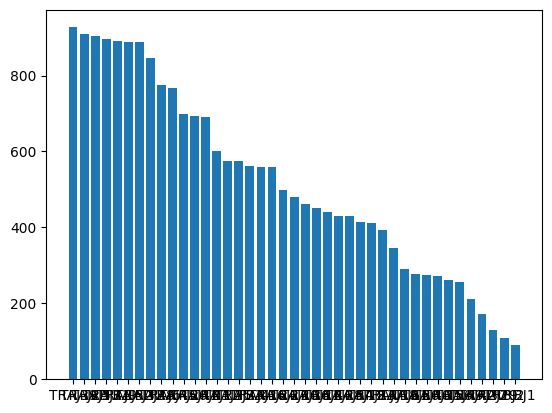

In [77]:
plt.bar(j_genes.j.unique(), j_genes.j.value_counts())

In [78]:
# j_resampled = balance_minority(j_genes, 'j', max_count=600)
# j_resampled = balance_majority(j_resampled, 'j', max_count=600)
# j_resampled.to_csv('j_genes_resampled.csv', index=False)

j_resampled = pd.read_csv('j_genes_resampled.csv')
j_resampled#.j.unique()

,cdr3aa,j
0,CATVPRMDSSYKLIF,TRAJ12
1,CAVMDSSYKLIF,TRAJ12
2,CAARMDSSYKLIF,TRAJ12
3,CAVRTDSSYKLIF,TRAJ12
4,CAGADSSYKLIF,TRAJ12
...,...,...
24161,CLLGAPLFGNEKLTF,TRAJ48
24162,CAVTNFGNEKLTF,TRAJ48
24163,CAGNFGNEKLTF,TRAJ48
24164,CAATFALPEKLTF,TRAJ48


<BarContainer object of 41 artists>

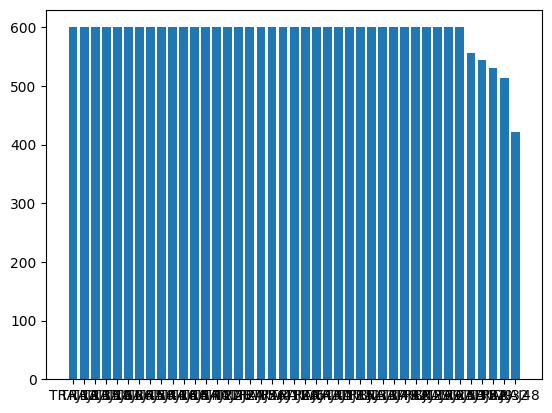

In [79]:
plt.bar(j_resampled.j.unique(), j_resampled.j.value_counts())

In [80]:
j_uniq = set(j_resampled.j.unique())
j_test_uniq = set(j_test_dataset.j.unique())

In [81]:
if not j_test_uniq.issubset(j_uniq):
    print('ADD to train df')
    diff = j_test_uniq.difference(j_uniq)
    for i in diff:
        j_resampled.loc[len(j_resampled.index)] = [j_test_dataset[j_test_dataset['j'] == i].iloc[0][0], i]
        print(j_test_dataset[j_test_dataset['j'] == i].iloc[0][0], i)
        

In [82]:
j_resampled['cdr3aa'] = j_resampled['cdr3aa'].apply(add_spaces)
j_test_dataset['cdr3aa'] = j_test_dataset['cdr3aa'].apply(add_spaces)

l_enc_j = LabelEncoder()
l_enc_j.fit(j_resampled['j'])
j_resampled['j'] = l_enc_j.transform(j_resampled['j'])
j_test_dataset['j'] = l_enc_j.transform(j_test_dataset['j'])




In [83]:
mapping = dict(zip(l_enc_j.classes_, range(len(l_enc_j.classes_))))
mapping

{'TRAJ10': 0,
 'TRAJ11': 1,
 'TRAJ12': 2,
 'TRAJ13': 3,
 'TRAJ15': 4,
 'TRAJ16': 5,
 'TRAJ17': 6,
 'TRAJ18': 7,
 'TRAJ20': 8,
 'TRAJ23': 9,
 'TRAJ24': 10,
 'TRAJ27': 11,
 'TRAJ28': 12,
 'TRAJ29': 13,
 'TRAJ31': 14,
 'TRAJ32': 15,
 'TRAJ33': 16,
 'TRAJ35': 17,
 'TRAJ36': 18,
 'TRAJ37': 19,
 'TRAJ39': 20,
 'TRAJ4': 21,
 'TRAJ40': 22,
 'TRAJ41': 23,
 'TRAJ42': 24,
 'TRAJ43': 25,
 'TRAJ44': 26,
 'TRAJ45': 27,
 'TRAJ48': 28,
 'TRAJ49': 29,
 'TRAJ50': 30,
 'TRAJ52': 31,
 'TRAJ53': 32,
 'TRAJ54': 33,
 'TRAJ56': 34,
 'TRAJ6': 35,
 'TRAJ61': 36,
 'TRAJ7': 37,
 'TRAJ9': 38,
 'TRBJ1': 39,
 'TRBJ2': 40}

In [84]:
j_test_dataset = j_test_dataset.reset_index(drop=True)
j_ans = j_test_dataset['j']

j_test_dataset = j_test_dataset.drop(columns=['j'])

In [85]:
j_resampled

,cdr3aa,j
0,C A T V P R M D S S Y K L I F,2
1,C A V M D S S Y K L I F,2
2,C A A R M D S S Y K L I F,2
3,C A V R T D S S Y K L I F,2
4,C A G A D S S Y K L I F,2
...,...,...
24161,C L L G A P L F G N E K L T F,28
24162,C A V T N F G N E K L T F,28
24163,C A G N F G N E K L T F,28
24164,C A A T F A L P E K L T F,28


## Train the model

### Prottrans

In [100]:
j_train_df, j_val_df = train_test_split(j_resampled, test_size=0.2, random_state=42)

In [176]:
j_train_df = j_train_df.rename({'cdr3aa': 'sequence', 'j': 'label'}, axis=1)
j_val_df = j_val_df.rename({'cdr3aa': 'sequence', 'j': 'label'}, axis=1)
j_train_df["sequence"] = j_train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
j_val_df["sequence"] = j_val_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    
j_val_df

,sequence,label
18398,C A V E S S N F G N E K L T F,28
11773,C A T G R S S N T G K L I F,19
12876,C A S S V T G G L R T N E Q F F,40
12256,C A V P S S G N T P L V F,13
16515,C A A F T G G G N K L T F,0
...,...,...
4325,C A E N L E P R G K L I F,6
13054,C A V S G A G N Q F Y F,29
16259,C A E R I T G G G N K L T F,0
11206,C A E G T P S N T G K L I F,19


In [101]:
N_LABELS = len(j_resampled.j.value_counts())

j_tokenizer, j_model, j_history = train_per_protein(j_train_df, j_val_df, num_labels=N_LABELS, batch=8, accum=8, epochs=5, seed=42)

In [178]:
my_test_j=j_test_dataset.rename({'cdr3aa': 'sequence'}, axis=1)
my_test_j["sequence"]=my_test_j["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)

my_test_j.head(5)

,sequence
0,C A E S S G G S Y I P T F
1,C A S S R A A G Q G V S Y N S P L H F
2,C A G R A N F G N E K L T F
3,C A A S A R S G Y A L N F
4,C A A N P G A N N L F F


In [179]:
# create Dataset
test_set=create_dataset(j_tokenizer, list(my_test_j['sequence']),list(j_ans))

test_set = test_set.with_format("torch", device=device)
test_dataloader = DataLoader(test_set, batch_size=8, shuffle=False)


j_model.eval()

# Make predictions on the test dataset
predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #add batch results(logits) to predictions
        predictions += j_model(input_ids, attention_mask=attention_mask).logits.tolist()

100%|██████████| 296/296 [00:20<00:00, 14.18it/s]


In [180]:
predictions= [item.argmax() for item in np.array(predictions)]
print("F1 score: ", f1_score(list(j_ans), predictions, average='macro'))

F1 score:  0.8038587413923719


In [40]:
N_LABELS = len(j_resampled.j.value_counts())

#save_model(j_model,"./Prottrans_j_genes_finetuned.pth")
tokenizer_1, model_reload = load_model_("./Prottrans_j_genes_finetuned.pth", num_labels=N_LABELS, mixed=False)

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.20.layer.1.EncDecAttention.q.weight', 'decoder.block.16.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight', 'decoder.block.15.layer.1.layer_norm.weight', 'decoder.block.23.layer.1.layer_norm.weight', 'decoder.block.5.layer.1.EncDecAttention.o.weight', 'decoder.block.23.layer.2.layer_norm.weight', 'decoder.block.12.layer.0.SelfAttention.v.weight', 'decoder.block.5.layer.1.layer_norm.weight', 'decoder.block.4.layer.1.EncDecAttention.o.weight', 'decoder.block.2.layer.1.layer_norm.weight', 'decoder.block.10.layer.1.EncDecAttention.k.weight', 'decoder.block.4.layer.2.DenseReluDense.wi.weight', 'decoder.block.11.layer.1.layer_norm.weight', 'decoder.block.6.layer.1.EncDecAttention.o.weight', 'decoder.block.12.layer.1.EncDecAttention.o.weight', 'decoder.block.22.layer.1.EncDecAttention.q.weight', 'decoder.block.20.layer.0.layer_nor

ProtT5_Classfier
Trainable Parameter: 1209233449
ProtT5_LoRA_Classfier
Trainable Parameter: 3599401



### TCR bert

In [64]:
N_LABELS = len(j_resampled.j.value_counts())
my_model = CustomModel(n_labels=N_LABELS)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([41, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([41]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
j_resampled['j']

0         2
1         2
2         2
3         2
4         2
         ..
24161    28
24162    28
24163    28
24164    28
24165    28
Name: j, Length: 24166, dtype: int64

In [66]:
input_ids, attention_masks, labels = my_model.tokenize(j_resampled['cdr3aa'], j_resampled['j'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [67]:
train_dataset, val_dataset = my_model.split_data(input_ids, attention_masks, labels)

19,332 training samples
4,834 validation samples


In [68]:
my_model.fit(train_dataset, val_dataset, epochs=8)


======== Epoch 1 / 8 ========
Training...

  Average training loss: 0.56
  Training epcoh took: 0:00:56

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.30
  Validation took: 0:00:03

======== Epoch 2 / 8 ========
Training...

  Average training loss: 0.28
  Training epcoh took: 0:00:56

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.28
  Validation took: 0:00:03

======== Epoch 3 / 8 ========
Training...

  Average training loss: 0.26
  Training epcoh took: 0:00:56

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.27
  Validation took: 0:00:03

======== Epoch 4 / 8 ========
Training...

  Average training loss: 0.24
  Training epcoh took: 0:00:55

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.26
  Validation took: 0:00:03

======== Epoch 5 / 8 ========
Training...

  Average training loss: 0.21
  Training epcoh took: 0:00:55

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.26
  Validation took: 0:00:03

======== Epoch 6 / 

In [69]:
my_model.get_stats()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.559638,0.300645,0.855611,0:00:56,0:00:03
2,0.283283,0.275877,0.869431,0:00:56,0:00:03
3,0.256361,0.268764,0.873144,0:00:56,0:00:03
4,0.237174,0.260444,0.878507,0:00:55,0:00:03
5,0.214615,0.263454,0.880363,0:00:55,0:00:03
6,0.189429,0.276699,0.877063,0:00:55,0:00:03
7,0.169100,0.287933,0.877888,0:00:55,0:00:03
8,0.147882,0.298507,0.881394,0:00:55,0:00:03


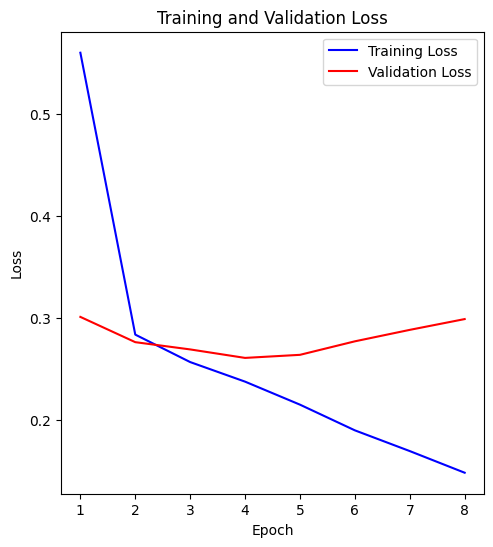

In [70]:
my_model.draw_stats_plot()

In [71]:
j_pred_labels = my_model.predict(j_test_dataset['cdr3aa'])
f1_sc = f1_score(j_ans, j_pred_labels, average='macro')
print('Total f1_score: %.5f' % f1_sc)

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Total f1_score: 0.90632


In [72]:
save_model(my_model, './TCR_bert_j_genes.pth')

In [86]:
N_LABELS = len(j_resampled.j.value_counts())
my_model = load_model_('./models_ft/TCR_bert_j_genes.pth',  mod_type='TCR-bert', num_labels=N_LABELS)
my_model.to(device)
# my_model.m

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomModel(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(26, 768, padding_idx=21)
        (position_embeddings): Embedding(64, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=

In [87]:
my_model.maximun_len = 25
j_preds = my_model.predict(j_test_dataset['cdr3aa'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


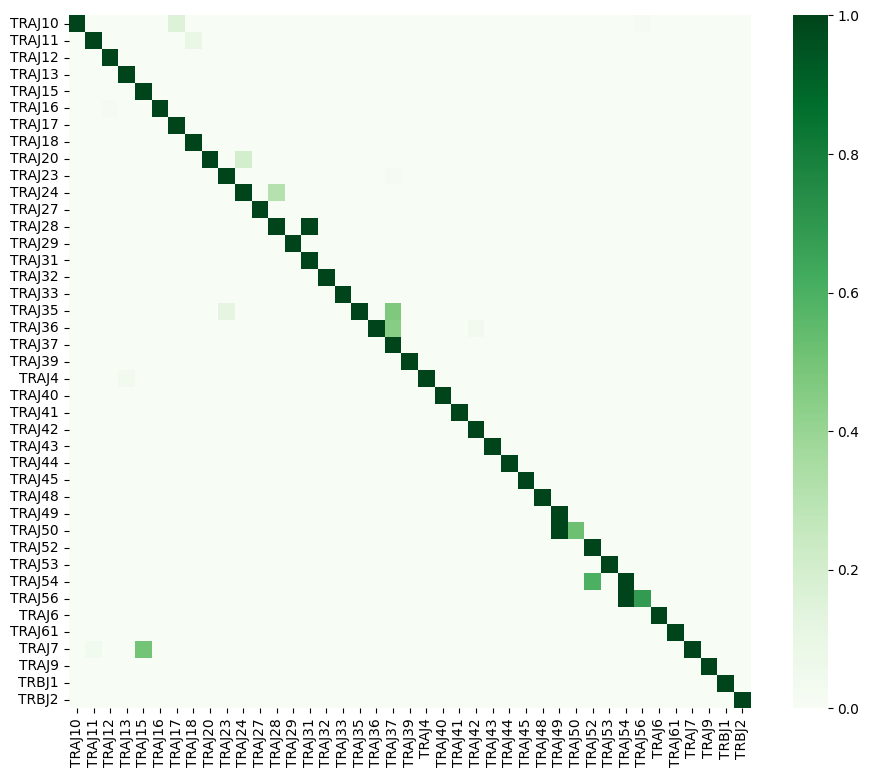

In [88]:
notm_matrix_j = draw_heatmap(j_ans, j_preds, l_enc_j)

In [89]:
f1_sc = f1_score(j_ans, j_preds, average='macro')
print('Total f1_score: %.5f' % f1_sc)

Total f1_score: 0.90632


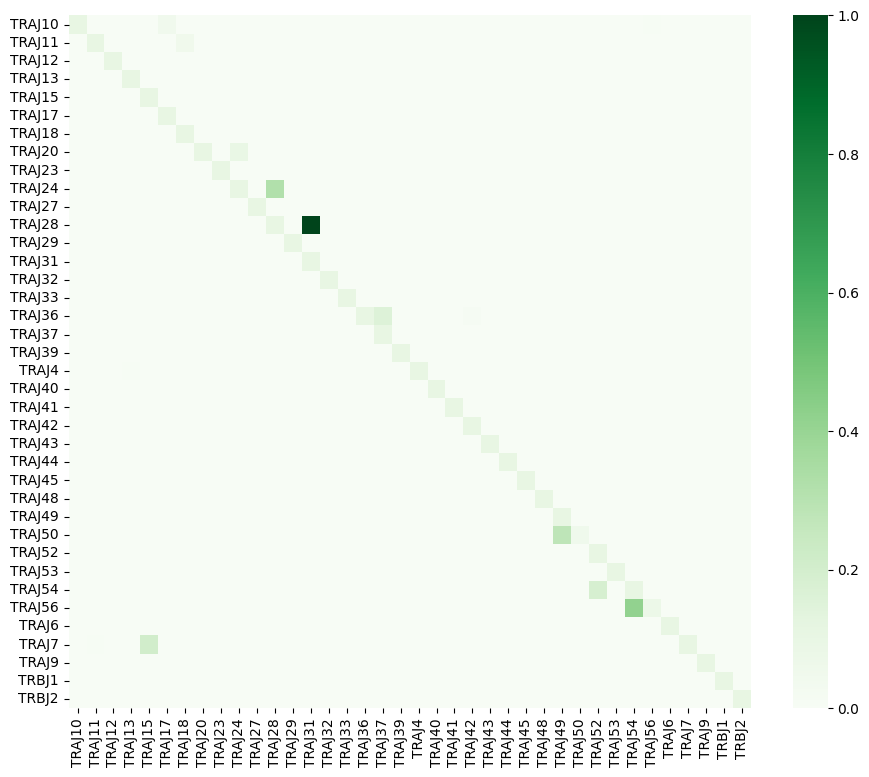

In [90]:
mist_dist_heatmap(notm_matrix_j, 'J')